In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
%matplotlib inline

In [2]:
df1 = pd.read_csv('uber_carpoolservice.csv')
df2 = pd.read_csv('lyft_carpoolservice.csv')

In [3]:
df1['uber_price_estimate'] = (df1['uber_max_estimate'] + df1['uber_min_estimate'])/2
df2['lyft_price_estimate'] = (df2['lyft_max_estimate'] + df2['lyft_min_estimate'])/2

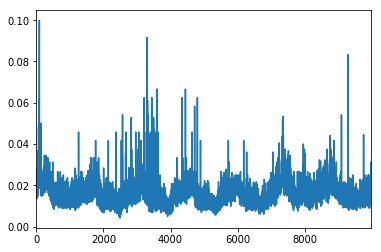

In [4]:
df1['uber_price_per_second'] = df1.uber_price_estimate/df1.uber_duration
df1['uber_price_per_second'].plot()

In [5]:
TS = np.array(df1['uber_price_per_second'])
num_periods = 100
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 100, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 100, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

99
(99, 100, 1)
[[[ 0.02037037]
  [ 0.01904762]
  [ 0.02083333]
  [ 0.01851852]
  [ 0.01851852]
  [ 0.02083333]
  [ 0.01818182]
  [ 0.01833333]
  [ 0.02142857]
  [ 0.01851852]
  [ 0.01851852]
  [ 0.01904762]
  [ 0.01388889]
  [ 0.02083333]
  [ 0.01851852]
  [ 0.01759259]
  [ 0.02142857]
  [ 0.01818182]
  [ 0.02142857]
  [ 0.01527778]
  [ 0.01833333]
  [ 0.01458333]
  [ 0.01666667]
  [ 0.01770833]
  [ 0.01666667]
  [ 0.01354167]
  [ 0.01666667]
  [ 0.025     ]
  [ 0.025     ]
  [ 0.028125  ]
  [ 0.01818182]
  [ 0.01805556]
  [ 0.02407407]
  [ 0.0219697 ]
  [ 0.01785714]
  [ 0.01875   ]
  [ 0.01851852]
  [ 0.02583333]
  [ 0.02083333]
  [ 0.01818182]
  [ 0.01875   ]
  [ 0.02685185]
  [ 0.02083333]
  [ 0.02083333]
  [ 0.0202381 ]
  [ 0.01904762]
  [ 0.02261905]
  [ 0.03690476]
  [ 0.02380952]
  [ 0.03257576]
  [ 0.02291667]
  [ 0.03095238]
  [ 0.0202381 ]
  [ 0.01833333]
  [ 0.03055556]
  [ 0.02361111]
  [ 0.01481481]
  [ 0.0212963 ]
  [ 0.01851852]
  [ 0.03055556]
  [ 0.03181818]
  [ 0.01

In [6]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 100, 1)
    testY = TS[-(num_periods):].reshape(-1, 100, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 100, 1)
[[[ 0.01481481]
  [ 0.01805556]
  [ 0.01666667]
  [ 0.01203704]
  [ 0.01875   ]
  [ 0.01089744]
  [ 0.01410256]
  [ 0.00984848]
  [ 0.01547619]
  [ 0.01180556]
  [ 0.01083333]
  [ 0.01203704]
  [ 0.01527778]
  [ 0.01416667]
  [ 0.00972222]
  [ 0.01515152]
  [ 0.02037037]
  [ 0.01574074]
  [ 0.01309524]
  [ 0.01875   ]
  [ 0.01547619]
  [ 0.025     ]
  [ 0.01145833]
  [ 0.01203704]
  [ 0.025     ]
  [ 0.01547619]
  [ 0.01666667]
  [ 0.01833333]
  [ 0.01666667]
  [ 0.01785714]
  [ 0.02142857]
  [ 0.02142857]
  [ 0.01666667]
  [ 0.01388889]
  [ 0.01388889]
  [ 0.00897436]
  [ 0.01547619]
  [ 0.01145833]
  [ 0.01547619]
  [ 0.01083333]
  [ 0.01203704]
  [ 0.01212121]
  [ 0.00984848]
  [ 0.01666667]
  [ 0.0125    ]
  [ 0.01875   ]
  [ 0.01555556]
  [ 0.01944444]
  [ 0.01904762]
  [ 0.01666667]
  [ 0.01944444]
  [ 0.01875   ]
  [ 0.01904762]
  [ 0.01488095]
  [ 0.01851852]
  [ 0.01602564]
  [ 0.00902778]
  [ 0.01309524]
  [ 0.01547619]
  [ 0.01736111]
  [ 0.01833333]
  [ 0.016666

In [7]:
tf.reset_default_graph()

num_periods = 100
inputs = 1
hidden = 500
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.LSTMCell(num_units = hidden, forget_bias=1.0, initializer=tf.contrib.layers.xavier_initializer())
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Applied Xavier Uniform as a form of network initialization

In [9]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 4.58989
100 	MSE: 0.231948
200 	MSE: 0.200404
300 	MSE: 0.20009
400 	MSE: 0.199933
500 	MSE: 0.199855
600 	MSE: 0.19978
700 	MSE: 0.199715
800 	MSE: 0.201336
900 	MSE: 0.199639
[[[ 0.01547414]
  [ 0.01688349]
  [ 0.01634644]
  [ 0.01539036]
  [ 0.0152873 ]
  [ 0.01493236]
  [ 0.01477208]
  [ 0.01432502]
  [ 0.01429229]
  [ 0.01409404]
  [ 0.01370984]
  [ 0.01340231]
  [ 0.01346488]
  [ 0.01356305]
  [ 0.01322628]
  [ 0.01324766]
  [ 0.01393337]
  [ 0.01437011]
  [ 0.01436998]
  [ 0.01473604]
  [ 0.01494284]
  [ 0.01592398]
  [ 0.01588153]
  [ 0.01541615]
  [ 0.01610557]
  [ 0.01634252]
  [ 0.0163971 ]
  [ 0.01656235]
  [ 0.01660965]
  [ 0.01670597]
  [ 0.01715444]
  [ 0.01769956]
  [ 0.01776134]
  [ 0.01735146]
  [ 0.01682074]
  [ 0.0158662 ]
  [ 0.0154449 ]
  [ 0.01494189]
  [ 0.01478891]
  [ 0.01437068]
  [ 0.01396844]
  [ 0.01364024]
  [ 0.01316071]
  [ 0.01329663]
  [ 0.01329794]
  [ 0.01378103]
  [ 0.01413149]
  [ 0.01471879]
  [ 0.01532181]
  [ 0.01563254]
  [ 0.01605137]

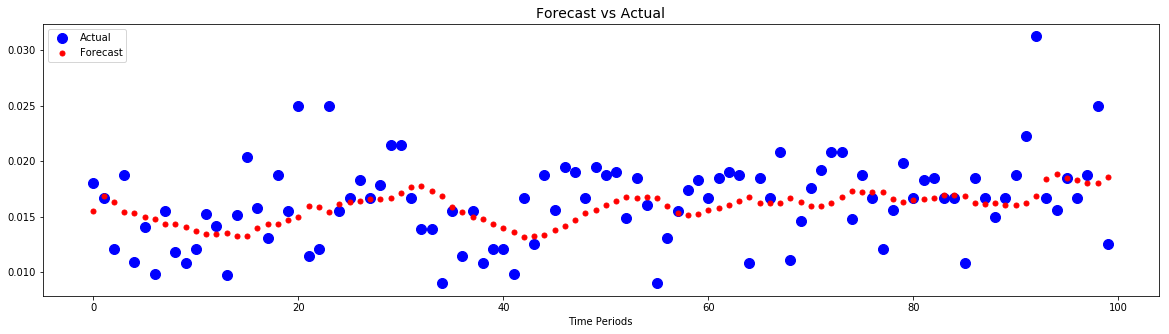

In [10]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

In [11]:
tf.reset_default_graph()

num_periods = 100
inputs = 1
hidden = 500
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.LSTMCell(num_units = hidden, forget_bias=1.0, initializer=tf.zeros_initializer)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Applied zeros as a form of network initialization

In [12]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 1.32446
100 	MSE: 0.290247
200 	MSE: 0.337563
300 	MSE: 0.367984
400 	MSE: 0.309375
500 	MSE: 0.309086
600 	MSE: 0.223851
700 	MSE: 0.202368
800 	MSE: 0.201718
900 	MSE: 0.201298
[[[ 0.0157492 ]
  [ 0.01620248]
  [ 0.01619461]
  [ 0.01575507]
  [ 0.01644551]
  [ 0.01506675]
  [ 0.0154545 ]
  [ 0.01431299]
  [ 0.0148732 ]
  [ 0.01396664]
  [ 0.01373483]
  [ 0.01354497]
  [ 0.01378488]
  [ 0.01360006]
  [ 0.01302051]
  [ 0.01370765]
  [ 0.01441398]
  [ 0.01418782]
  [ 0.01425066]
  [ 0.01516856]
  [ 0.0148535 ]
  [ 0.01671681]
  [ 0.01509093]
  [ 0.01560238]
  [ 0.01715973]
  [ 0.01600585]
  [ 0.01673905]
  [ 0.01686777]
  [ 0.01677207]
  [ 0.01706754]
  [ 0.01766803]
  [ 0.01796453]
  [ 0.01766534]
  [ 0.01737876]
  [ 0.01711229]
  [ 0.01595439]
  [ 0.01638704]
  [ 0.01520729]
  [ 0.01557984]
  [ 0.01449218]
  [ 0.01445431]
  [ 0.01401326]
  [ 0.01338715]
  [ 0.01411036]
  [ 0.01333919]
  [ 0.01447183]
  [ 0.01409946]
  [ 0.01513713]
  [ 0.01539891]
  [ 0.01558582]
  [ 0.0163539

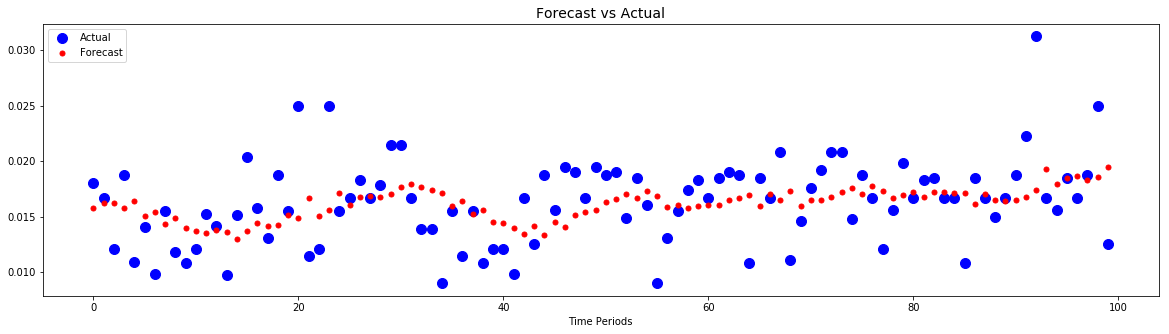

In [13]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()